In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'thyroid-disease-data-set:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1027034%2F1730566%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240622%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240622T085207Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2bc981e0143fa7a37f37a4814f289599c505f8d19c697db5020b9b1c02cb04c8da07384b52a28b04821836a0ae35fb822b8c90433ceb0cd558ba28eb851f6dde5adad21f3984c9d127fe1a34231bfa0fb6bb38394676cb4597a5212d68498725ee5ec10c3972369e450a51d2bea1141043d738dc6dba4b35ed3a3bdcb0f8650c3c245d7067447eab6aa89e96e6cd65092e20474b4e17f107cd794e32040eaec81a4377cb9675af80163d79a2e98351913e54140311a80aba8cd4e2b9a13d43b728204250acaf865a50429e5daab6c569d0d5266beb728de82b56e5356322edfeb625a782dff09d199b8fad9bd587626ff16d6683c9d77e3d2a157c0fa4bf2a3f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 49962 bytes downloaded
Downloaded and uncompressed: thyroid-disease-data-set
Data source import complete.


## **Introduction**

## **Import Libraries**

In [2]:
#pandas
import pandas as pd

#numpy
import numpy as np

#matplotlib
import matplotlib.pyplot as plt

#seaborn
import seaborn as sns

#sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle
import warnings


## **Read data from csv**

In [42]:
thyroid_df = pd.read_csv('/hypothyroid.csv')
thyroid_df.head(n=20)

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,P
5,18,F,t,f,f,f,f,f,f,f,...,t,183,t,1.3,t,141,f,?,other,P
6,59,F,f,f,f,f,f,f,f,f,...,t,72,t,0.92,t,78,f,?,other,P
7,80,F,f,f,f,f,f,f,f,f,...,t,80,t,0.7,t,115,f,?,SVI,P
8,66,F,f,f,f,f,f,f,f,f,...,t,123,t,0.93,t,132,f,?,SVI,P
9,68,M,f,f,f,f,f,f,f,f,...,t,83,t,0.89,t,93,f,?,SVI,P


In [41]:
thyroid_df.shape

(3772, 30)

## **Data Cleaning**

In [4]:
thyroid_df.rename(columns={'binaryClass':'Label'},inplace=True)

In [5]:
thyroid_df.replace('?',np.nan,inplace=True)

In [6]:
thyroid_df.drop(['T3 measured','TSH measured','TT4 measured','T4U measured','FTI measured','TBG measured','TBG','referral source','on thyroxine','query on thyroxine','on antithyroid medication','query hypothyroid', 'query hyperthyroid','hypopituitary', 'psych'],axis=1,inplace=True)

In [7]:
thyroid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              3771 non-null   object
 1   sex              3622 non-null   object
 2   sick             3772 non-null   object
 3   pregnant         3772 non-null   object
 4   thyroid surgery  3772 non-null   object
 5   I131 treatment   3772 non-null   object
 6   lithium          3772 non-null   object
 7   goitre           3772 non-null   object
 8   tumor            3772 non-null   object
 9   TSH              3403 non-null   object
 10  T3               3003 non-null   object
 11  TT4              3541 non-null   object
 12  T4U              3385 non-null   object
 13  FTI              3387 non-null   object
 14  Label            3772 non-null   object
dtypes: object(15)
memory usage: 442.2+ KB


In [8]:
thyroid_df['thyroid surgery'].value_counts()

thyroid surgery
f    3719
t      53
Name: count, dtype: int64

In [9]:
cols = ['age','FTI','TSH','T3','TT4','T4U']
for i in cols:
    thyroid_df[i] = pd.to_numeric(thyroid_df[i])

In [10]:
thyroid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3771 non-null   float64
 1   sex              3622 non-null   object 
 2   sick             3772 non-null   object 
 3   pregnant         3772 non-null   object 
 4   thyroid surgery  3772 non-null   object 
 5   I131 treatment   3772 non-null   object 
 6   lithium          3772 non-null   object 
 7   goitre           3772 non-null   object 
 8   tumor            3772 non-null   object 
 9   TSH              3403 non-null   float64
 10  T3               3003 non-null   float64
 11  TT4              3541 non-null   float64
 12  T4U              3385 non-null   float64
 13  FTI              3387 non-null   float64
 14  Label            3772 non-null   object 
dtypes: float64(6), object(9)
memory usage: 442.2+ KB


## **Handle Missing Values**

In [11]:
thyroid_df.isnull().sum()

age                  1
sex                150
sick                 0
pregnant             0
thyroid surgery      0
I131 treatment       0
lithium              0
goitre               0
tumor                0
TSH                369
T3                 769
TT4                231
T4U                387
FTI                385
Label                0
dtype: int64

In [12]:
miss_cols = ['FTI','TSH','T3','TT4','T4U']
for i in miss_cols:
    thyroid_df[i] = thyroid_df[i].fillna(thyroid_df[i].mean())

In [13]:
thyroid_df.dropna(inplace=True)

In [14]:
thyroid_df.isnull().sum()

age                0
sex                0
sick               0
pregnant           0
thyroid surgery    0
I131 treatment     0
lithium            0
goitre             0
tumor              0
TSH                0
T3                 0
TT4                0
T4U                0
FTI                0
Label              0
dtype: int64

In [15]:
thyroid_df = thyroid_df.drop(1364)

In [16]:
thyroid_df.TT4 = thyroid_df.TT4.astype(int)
thyroid_df.FTI = thyroid_df.FTI.astype(int)
thyroid_df.age = thyroid_df.age.astype(int)

## **EDA**

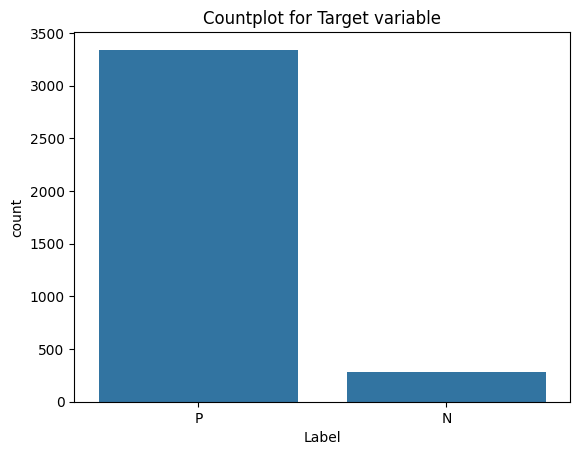

In [17]:
sns.countplot(x='Label',data=thyroid_df)
plt.title("Countplot for Target variable");

In [18]:
positive_df = thyroid_df[thyroid_df.Label=='P']

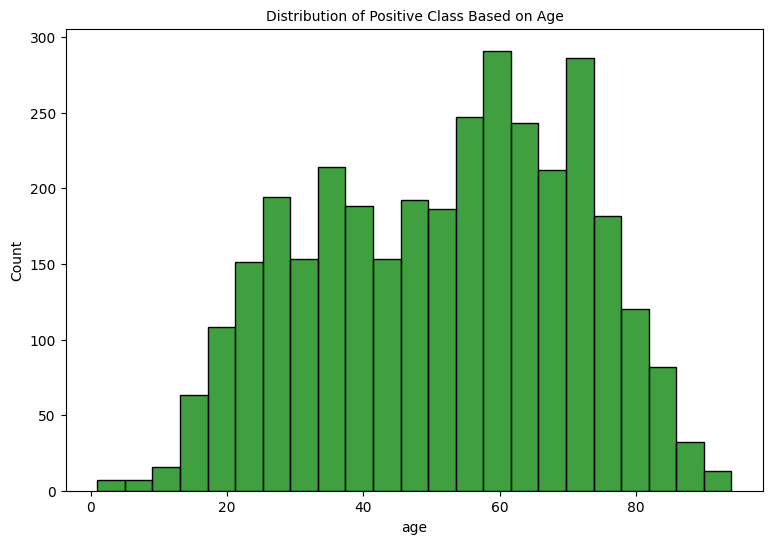

In [19]:
plt.figure(figsize=(9,6))
sns.histplot(x='age',data=positive_df,color='green')
plt.title("Distribution of Positive Class Based on Age",{'fontsize':10});

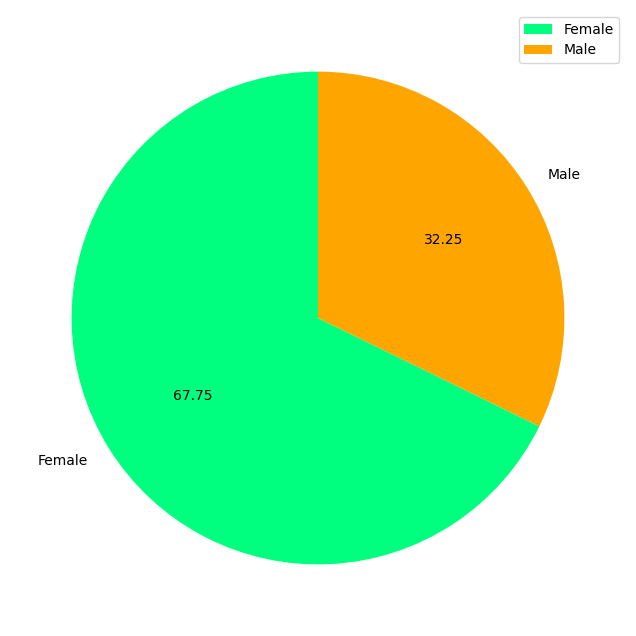

In [20]:
plt.figure(figsize=(10,8))
plt.pie(x=positive_df.sex.value_counts(),
        labels=['Female','Male'],
        startangle = 90,
        colors=['springgreen','orange'],
        autopct='%.2f'
       );
plt.legend();

## **Inference :**
### Female patients who has disease is greater than male patients.

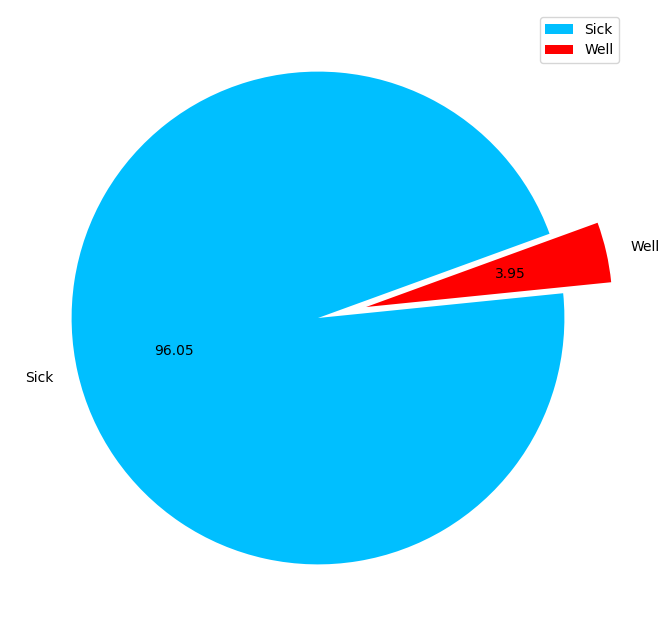

In [21]:
plt.figure(figsize=(8,8))
plt.pie(x=positive_df.sick.value_counts(),
        labels=['Sick','Well'],
        startangle = 20,
        colors=['deepskyblue','red'],
        autopct='%.2f',
        explode=[0,0.2]
       );
plt.legend();

In [22]:
X = thyroid_df.drop('Label',axis=1)
y = thyroid_df.Label

## **Transform non-numerical labels to numerical labels.**

In [23]:
s_encoder = LabelEncoder()
si_encoder = LabelEncoder()
preg_encoder = LabelEncoder()
th_encoder = LabelEncoder()
treat_encoder = LabelEncoder()
lith_encoder = LabelEncoder()
g_encoder= LabelEncoder()
tu_encoder = LabelEncoder()

In [24]:
X['sex'] = s_encoder.fit_transform(X.sex)
X['I131 treatment'] = treat_encoder.fit_transform(X['I131 treatment'])
X['sick'] = si_encoder.fit_transform(X.sick)
X['pregnant'] = preg_encoder.fit_transform(X.pregnant)
X['thyroid surgery'] = th_encoder.fit_transform(X['thyroid surgery'])
X['lithium'] = lith_encoder.fit_transform(X['lithium'])
X['goitre'] = g_encoder.fit_transform(X['goitre'])
X['tumor'] = tu_encoder.fit_transform(X['tumor'])

In [25]:
def func(df):
    if df == 'P':
        return 1
    else:
        return 0

In [26]:
y = y.apply(func)

## **Split original data into training data and testing data.**

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=11)

## **Handle Imbalance Data**

In [28]:
smote = SMOTE(random_state=11)

x_smote, y_smote = smote.fit_resample(X_train, y_train)

In [29]:
print("Shape before the Oversampling : ",X_train.shape)
print("Shape after the Oversampling : ",x_smote.shape)


Shape before the Oversampling :  (2896, 14)
Shape after the Oversampling :  (5340, 14)


## **Scaling (Normalization)**

In [30]:
scalr = MinMaxScaler()
x_smote.TT4 = scalr.fit_transform(x_smote[['TT4']])
x_smote.age = scalr.fit_transform(x_smote[['age']])
x_smote.FTI = scalr.fit_transform(x_smote[['FTI']])

In [31]:
# X_test.TT4 = scalr.transform(X_test[['TT4']])
# X_test.age = scalr.transform(X_test[['age']])
# X_test.FTI = scalr.transform(X_test[['FTI']])

## **Build Models.**

In [32]:
models = {
    LogisticRegression(max_iter=500):'Logistic Regression',
    SVC():"Support Vector Machine",
    RandomForestClassifier():'Random Forest',
    KNeighborsClassifier(n_neighbors=5):'KNN',
    DecisionTreeClassifier():'Decision Tree'
}
for m in models.keys():
    m.fit(x_smote,y_smote)
for model,name in models.items():
     print(f"Accuracy Score for {name} is : ",model.score(X_test,y_test)*100,"%")

Accuracy Score for Logistic Regression is :  92.95580110497238 %
Accuracy Score for Support Vector Machine is :  7.458563535911603 %
Accuracy Score for Random Forest is :  93.37016574585635 %
Accuracy Score for KNN is :  95.30386740331491 %
Accuracy Score for Decision Tree is :  98.61878453038673 %


## **Inference :**
### The most of patients who suffer from thyroid belonging to age group between 50-70

## **Classification Report for each model.**

In [33]:
for model,name in models.items():
    y_pred = model.predict(X_test)
    print(f"Classification Report for {name}")
    print("----------------------------------------------------------")
    print(classification_report(y_test,y_pred))
    print("----------------------------------------------------------")

Classification Report for Logistic Regression
----------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        54
           1       0.93      1.00      0.96       670

    accuracy                           0.93       724
   macro avg       0.96      0.53      0.53       724
weighted avg       0.93      0.93      0.90       724

----------------------------------------------------------
Classification Report for Support Vector Machine
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.07      1.00      0.14        54
           1       0.00      0.00      0.00       670

    accuracy                           0.07       724
   macro avg       0.04      0.50      0.07       724
weighted avg       0.01      0.07      0.01       724

----------------------------------------------------------
Classification 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
rf = RandomForestClassifier()
rf.fit(x_smote,y_smote)
rf.score(X_test,y_test)

0.925414364640884

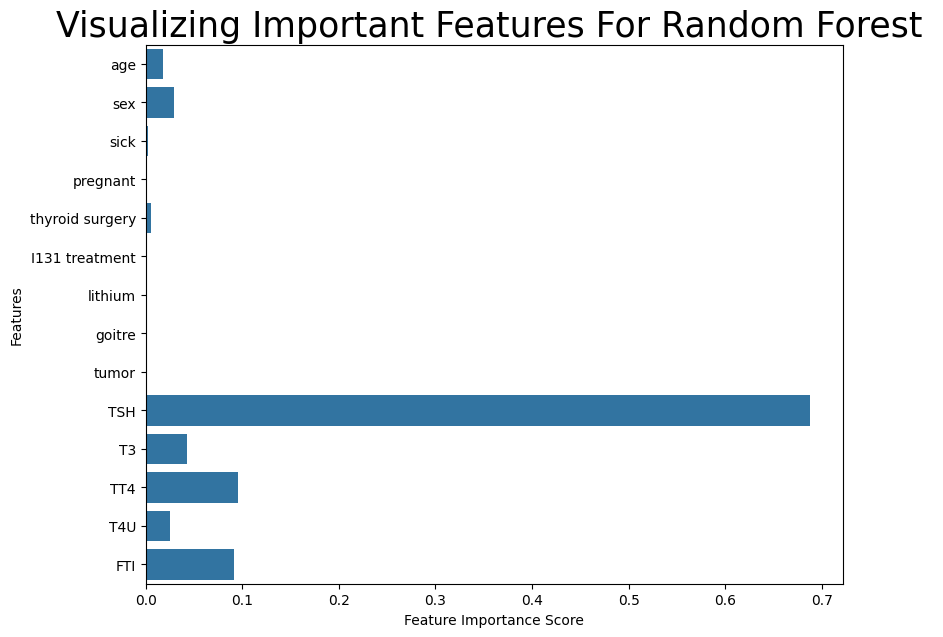

In [35]:
plt.figure(figsize=(9,7))
feature_imp1 = rf.feature_importances_
sns.barplot(x=feature_imp1, y=X.columns)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features For Random Forest ",{'fontsize':25})
plt.show();

In [36]:
x_smote.drop(['sick', 'pregnant', 'I131 treatment',
              'lithium', 'goitre', 'tumor'], axis=1, inplace=True)
X_test.drop(['sick', 'pregnant', 'I131 treatment',
              'lithium', 'goitre', 'tumor'], axis=1, inplace=True)


In [37]:
new_rf = RandomForestClassifier()
new_rf.fit(x_smote,y_smote)
new_rf.score(X_test,y_test)

0.9350828729281768

In [38]:
# with open('thyroid.pkl','wb') as f:
#     pickle.dump(new_rf,f)

In [39]:
thyroid_df.head()

,age,sex,sick,pregnant,thyroid surgery,I131 treatment,lithium,goitre,tumor,TSH,T3,TT4,T4U,FTI,Label
0,41,F,f,f,f,f,f,f,f,1.30,2.5000,125,1.140,109,P
1,23,F,f,f,f,f,f,f,f,4.10,2.0000,102,0.995,110,P
2,46,M,f,f,f,f,f,f,f,0.98,2.0135,109,0.910,120,P
3,70,F,f,f,f,f,f,f,f,0.16,1.9000,175,0.995,110,P
4,70,F,f,f,f,f,f,f,f,0.72,1.2000,61,0.870,70,P


## **Conclusion**

### Thyroid disease is one of the diseases that afflict the world’s population, and the number of cases of this disease is increasing. Because of medical reports that show serious imbalances in thyroid diseases, ourstudy deals with the classification of thyroid disease between hyperthyroidism and hypothyroidism. This disease was classified using algorithms. Machine learning showed us good results using several algorithms and was built in the form of two models.